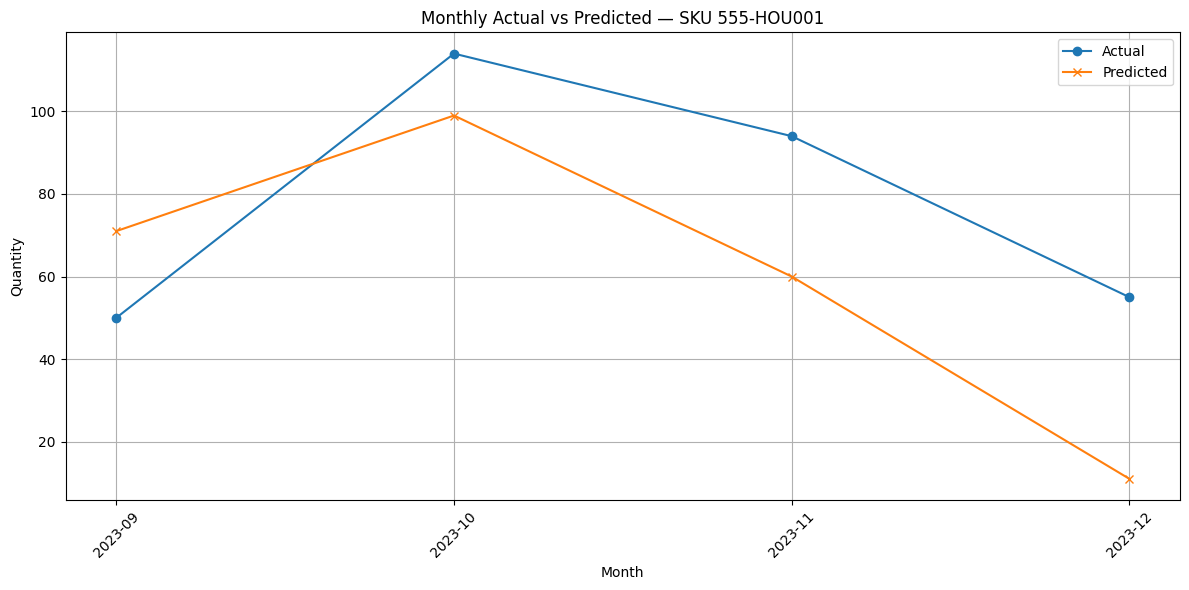

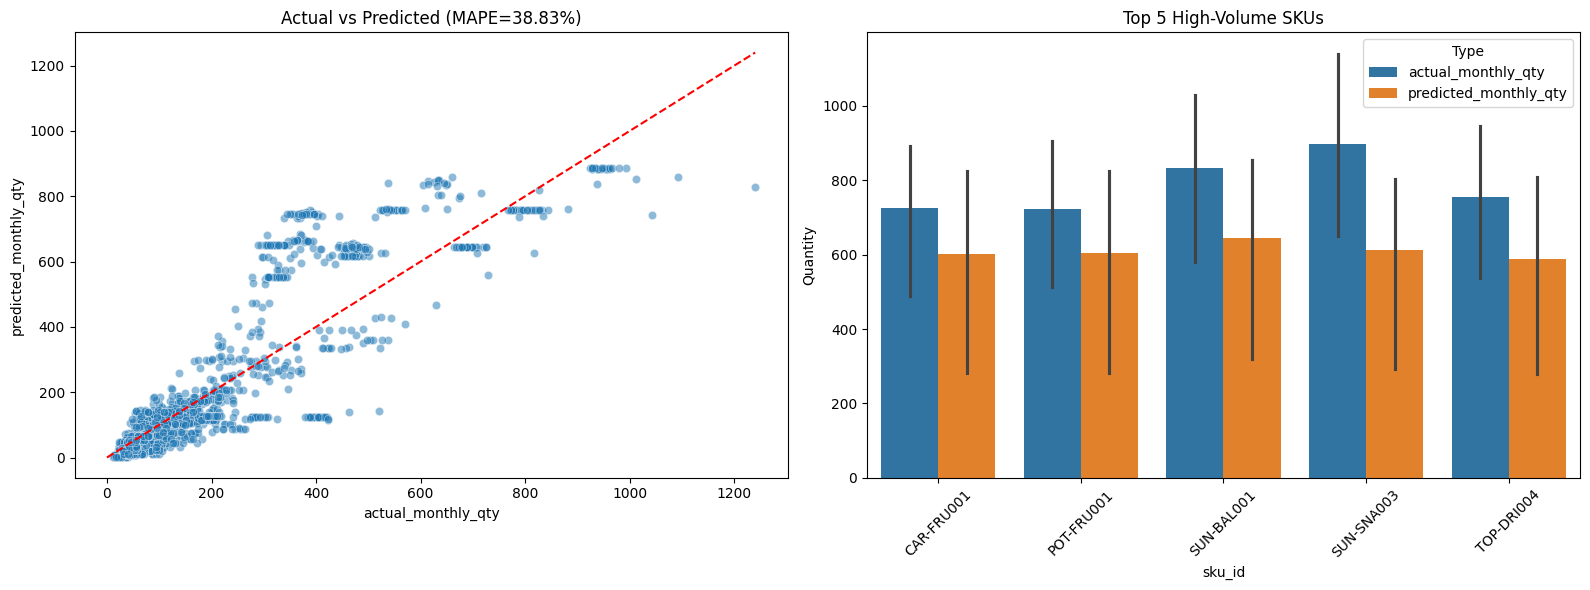

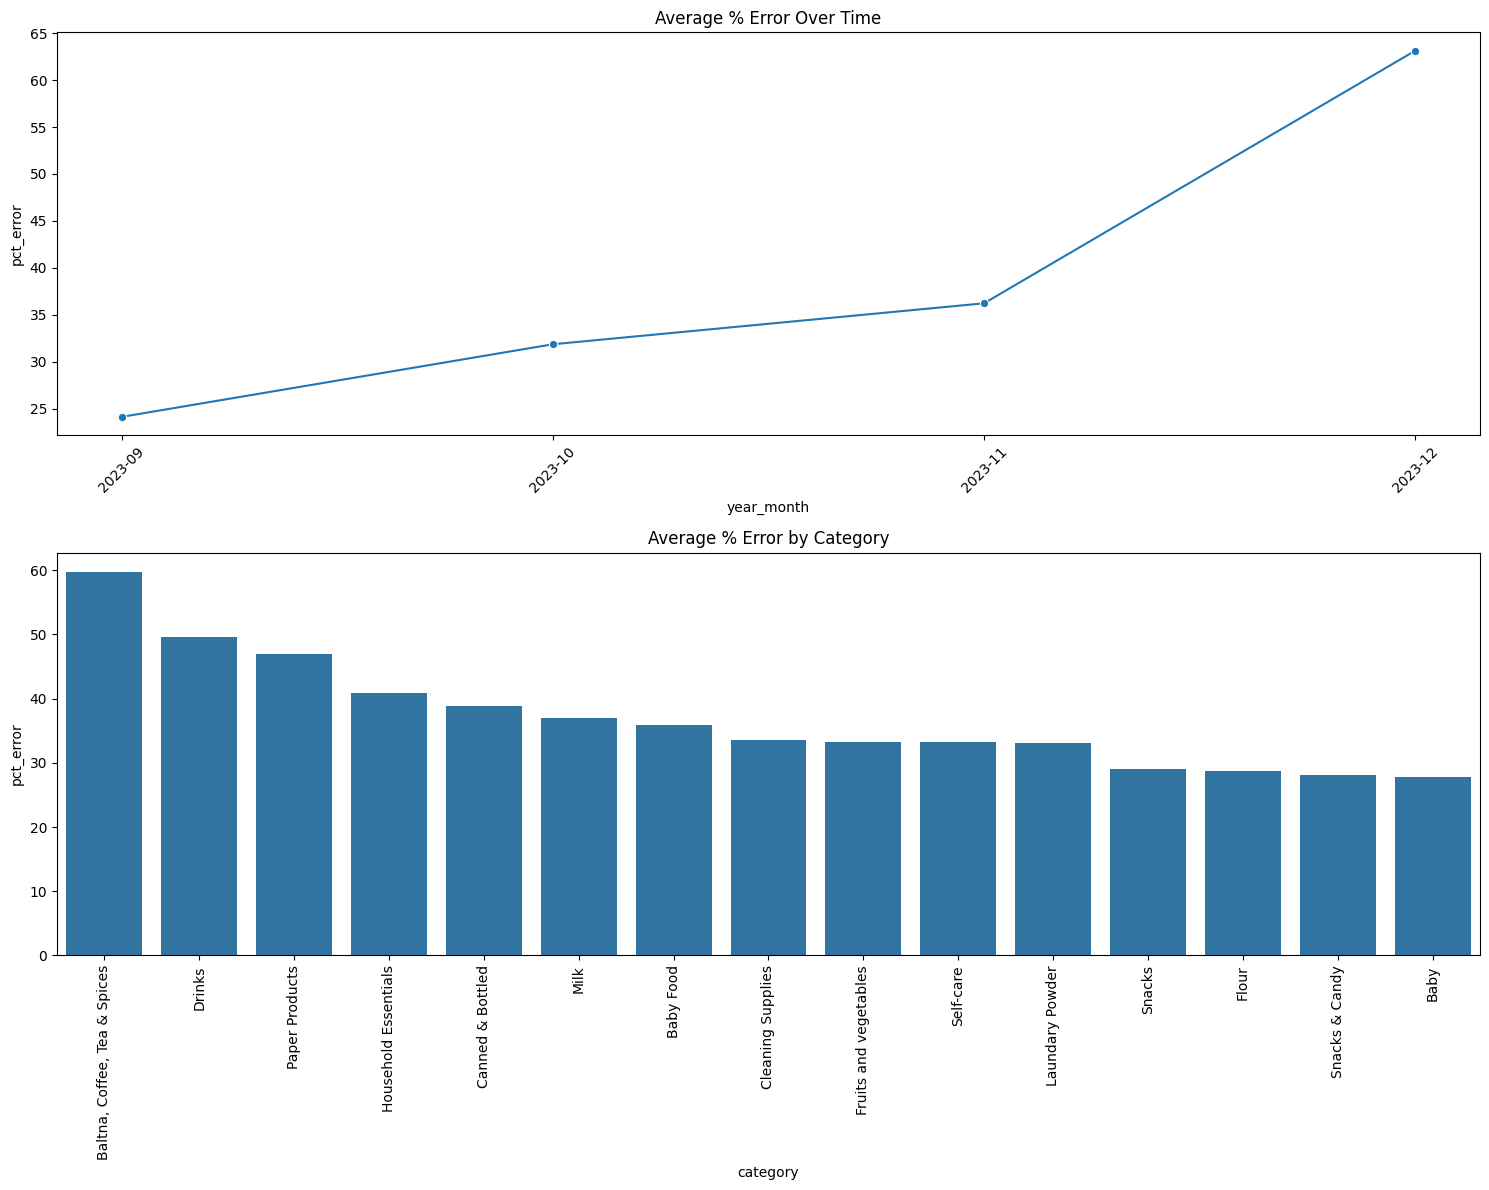

In [1]:
import pandas as pd
from src.visualization import (
    plot_monthly_actual_vs_pred,
    plot_scatter_and_top_skus,
    plot_error_trends
)

monthly_results = pd.read_csv(
    "../data/processed/rolling_monthly_vs_actual.csv"
)
monthly_results["year_month"] = pd.PeriodIndex(
    monthly_results["year_month"], freq="M"
)

sku_category_df = pd.read_csv(
    "../data/processed/test_data.csv",
    usecols=["sku_id", "category"]
).drop_duplicates()

sample_sku = monthly_results["sku_id"].iloc[0]

plot_monthly_actual_vs_pred(
    monthly_results,
    sample_sku,
    save_path="../reports/figures/rolling_sample_sku_monthly.png"
)

plot_scatter_and_top_skus(
    monthly_results,
    top_n=5,
    save_path="../reports/figures/rolling_scatter_top_skus.png"
)

plot_error_trends(
    monthly_results,
    sku_category_df,
    save_path="../reports/figures/rolling_error_trends.png"
)


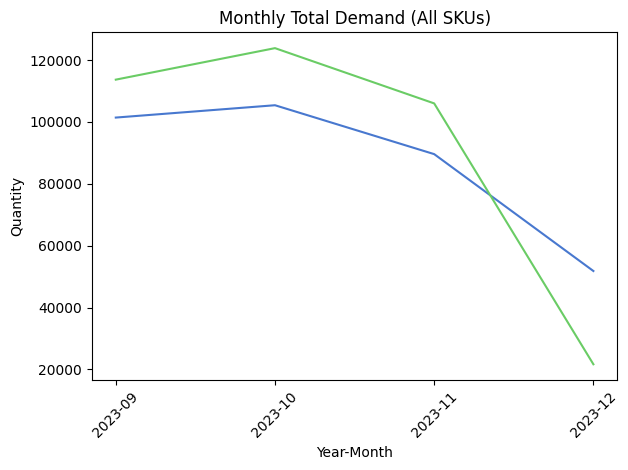

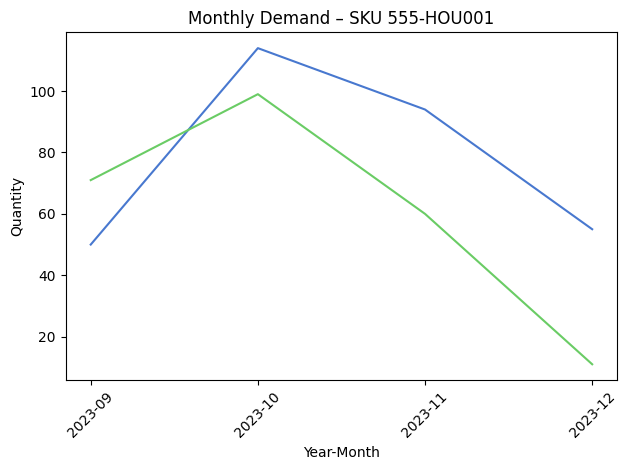

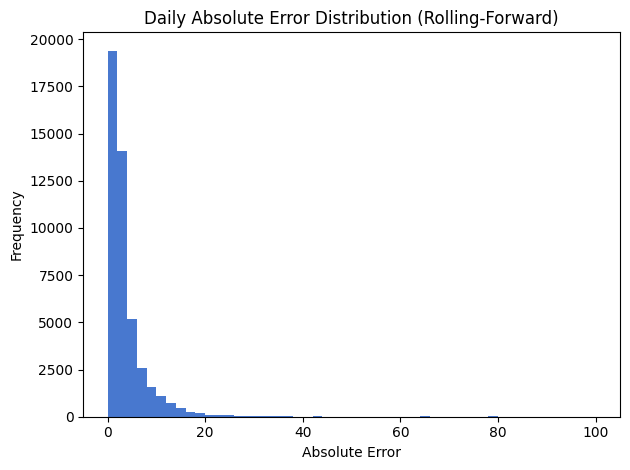

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# FIX THESE TWO PATHS ONLY
# ============================
DAILY_COMPARE_PATH = DATA_PROCESSED / "rolling_daily_vs_actual.csv"
MONTHLY_COMPARE_PATH = DATA_PROCESSED / "rolling_monthly_vs_actual.csv"

# ----------------------------
# LOAD DATA
# ----------------------------
daily_df = pd.read_csv(DAILY_COMPARE_PATH, parse_dates=["date"])
monthly_df = pd.read_csv(MONTHLY_COMPARE_PATH)

# ----------------------------
# 1) MONTHLY TOTAL (ALL SKUs)
# ----------------------------
monthly_total = (
    monthly_df
    .groupby("year_month")[["actual_qty", "predicted_qty"]]
    .sum()
    .reset_index()
)

monthly_total["year_month"] = monthly_total["year_month"].astype(str)

plt.figure()
plt.plot(monthly_total["year_month"], monthly_total["actual_qty"])
plt.plot(monthly_total["year_month"], monthly_total["predicted_qty"])
plt.xticks(rotation=45)
plt.title("Monthly Total Demand (All SKUs)")
plt.xlabel("Year-Month")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

# ----------------------------
# 2) SINGLE SKU MONTHLY VIEW
# ----------------------------
example_sku = monthly_df["sku_id"].iloc[0]

sku_monthly = monthly_df[monthly_df["sku_id"] == example_sku].copy()
sku_monthly["year_month"] = sku_monthly["year_month"].astype(str)

plt.figure()
plt.plot(sku_monthly["year_month"], sku_monthly["actual_qty"])
plt.plot(sku_monthly["year_month"], sku_monthly["predicted_qty"])
plt.xticks(rotation=45)
plt.title(f"Monthly Demand – SKU {example_sku}")
plt.xlabel("Year-Month")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

# ----------------------------
# 3) DAILY ERROR DISTRIBUTION
# ----------------------------
plt.figure()
plt.hist(daily_df["abs_error"], bins=50)
plt.title("Daily Absolute Error Distribution (Rolling-Forward)")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


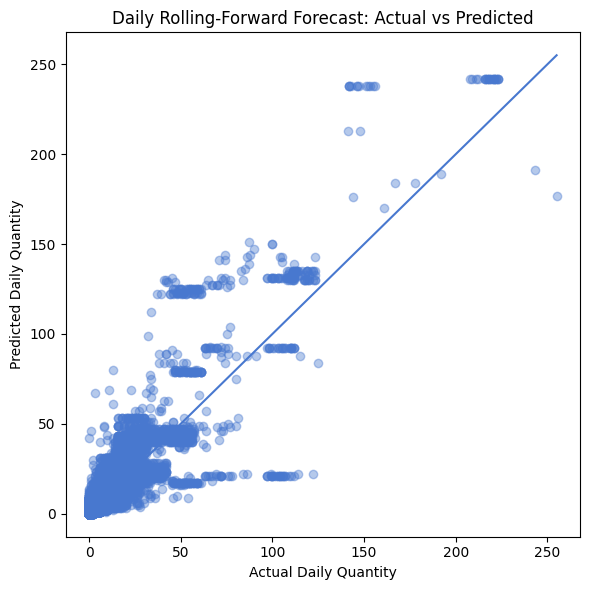

In [7]:
# Daily scatter plot
import pandas as pd
import matplotlib.pyplot as plt

# Load comparison file (adjust path if needed)
daily = pd.read_csv(
    DATA_PROCESSED / "rolling_daily_vs_actual.csv"
)

plt.figure(figsize=(6, 6))
plt.scatter(
    daily["target_qty"],
    daily["predicted_qty"],
    alpha=0.4
)

# 45-degree reference line (perfect predictions)
max_val = max(daily["target_qty"].max(), daily["predicted_qty"].max())
plt.plot([0, max_val], [0, max_val])

plt.xlabel("Actual Daily Quantity")
plt.ylabel("Predicted Daily Quantity")
plt.title("Daily Rolling-Forward Forecast: Actual vs Predicted")
plt.tight_layout()
plt.show()

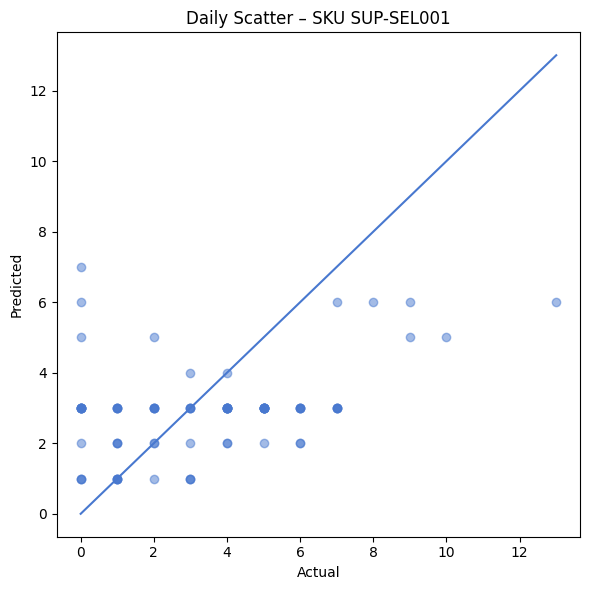

In [9]:
# Per SKU scatter plot
sku_id = daily["sku_id"].iloc[0]  # pick any SKU you want

sku_daily = daily[daily["sku_id"] == sku_id]

plt.figure(figsize=(6, 6))
plt.scatter(
    sku_daily["target_qty"],
    sku_daily["predicted_qty"],
    alpha=0.5
)

max_val = max(sku_daily["target_qty"].max(), sku_daily["predicted_qty"].max())
plt.plot([0, max_val], [0, max_val])

plt.title(f"Daily Scatter – SKU {sku_id}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()
